# Prueba de Ciencia de Datos

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor



## 1. Importación de datos

### Diccionario de datos


* **id_compra** : ID asociador de cada orden de compra 
* **id_proveedor** : ID de cada proveedor (a quien se le hace el pedido) 
* **id_empresa_facturadora** : ID de la empresa a la se emite la factura 
* **id_producto** : Asociador de cada SKU 
* **marca** : Marca del producto 
* **tamanio** : Tamaño de cada SKU 
* **cantidad** : Cantidades del producto en la linea de compra 
* **costo** : Costo de cada producto en la linea de compra 
* **monto_total_compra** : Monto total de la linea de compra (cantidad * costo) 
fecha_creacion  Fecha en que se emite el pedido al proveedor 
* **fecha_entrega** : Fecha en la que se recibio el producto 
* **dias_entrega (target)** : Numero de dias entre fecha_creacion y fecha_entrega 
* **sucursal_destino** : Almacen donde va dirigido el pedido 
* **tipo_venta** : Categorizacion del pedido: Stock: para abastecimiento bodegas propias (Retail), Calzada: venta directa al cliente (no se almacena en bodega) 
* **importado** : Determina si un producto viene del extrangero 
vendedor  Identificador del vendedor 

In [2]:
df = pd.read_csv('dataset_compras_proveedores.csv')
df.head()

,id_compra,id_proveedor,id_empresa_facturadora,id_producto,marca,tamanio,cantidad,costo,monto_total_compra,fecha_creacion,fecha_entrega,dias_entrega,sucursal_destino,tipo_venta,importado,vendedor
0,052_00205977,1202,1202,7753,277,E/50 1.20X12MT (14.4M2),950,7202,6841900,2017-10-26 14:33:58,2018-02-15 00:00:00,111,03,stock,0,9
1,052_00209555,318,318,2719,686,1ROLLO/100MT,7,34554,241878,2017-11-17 21:53:42,2018-01-18 00:00:00,61,02,stock,0,23
2,052_00210757,231,499,5307,628,700ML 28GR,40,424,16964,2017-11-24 21:30:54,2018-02-12 00:00:00,79,01,stock,0,23
3,052_00211183,915,915,2481,278,50X25X2.0MM,100,3792,379260,2017-11-28 18:32:13,2018-01-19 00:00:00,51,02,stock,0,22
4,052_00211951,1062,1062,441,715,10P,6,2340,14040,2017-12-04 12:38:02,2018-01-08 00:00:00,34,01,stock,0,9


## 2. Exploración de datos

### 2.1. Calidad y distribución de datos

Verificación de la completitud de los datos.

In [3]:
df.isnull().sum()/df.shape[0]

id_compra                 0.000000
id_proveedor              0.000000
id_empresa_facturadora    0.000000
id_producto               0.000000
marca                     0.000000
tamanio                   0.003604
cantidad                  0.000000
costo                     0.000000
monto_total_compra        0.000000
fecha_creacion            0.000000
fecha_entrega             0.000000
dias_entrega              0.000000
sucursal_destino          0.000000
tipo_venta                0.000000
importado                 0.000000
vendedor                  0.000000
dtype: float64

Tipo de variables en nuestro dataset de origen.

In [4]:
types = pd.DataFrame(df.dtypes)
print("Tipos de variables",types.groupby(0).size())

Tipos de variables 0
int64     10
object     6
dtype: int64


Cantidad de clases contenidas en las variables de tipo 'object'.

In [5]:
types = pd.DataFrame(df.dtypes)
categoricas = types.index[types[0] == 'O'].values
for line in categoricas:
    print(line +" contiene:",str(len(df[line].unique()))+" distinct values")

id_compra contiene: 108374 distinct values
tamanio contiene: 13995 distinct values
fecha_creacion contiene: 107976 distinct values
fecha_entrega contiene: 835 distinct values
sucursal_destino contiene: 6 distinct values
tipo_venta contiene: 2 distinct values


**Observaciones:**
* Las variables 'id_compra', 'tamanio' y 'fecha_creacion' tienen una cantidad demasiada alta de categorías como para proporcionarnos información por sí solas.

Estadistica de las variables en el dataset.
Solo se centemplan estas pues las restantes son del tipo categórico.

In [6]:
describe = df[['cantidad', 'costo', 'monto_total_compra', 'dias_entrega']].describe()
describe

,cantidad,costo,monto_total_compra,dias_entrega
count,359570.000000,3.595700e+05,3.595700e+05,359570.000000
mean,563.595225,1.450451e+04,3.021238e+05,8.715619
std,5225.115441,4.430539e+04,1.358796e+06,12.595190
min,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,6.000000,8.910000e+02,2.550000e+04,3.000000
50%,20.000000,2.971000e+03,7.445100e+04,6.000000
75%,100.000000,1.096600e+04,2.264132e+05,10.000000
max,700000.000000,4.420000e+06,2.145859e+08,505.000000


**Observaciones:**
* Las 4 variables podría tener outliers por la firencia del valor del tercel cuartil y el malor máximo.
* Recordemos que el 'monto_total_compra' = 'cantidad' * 'costo'

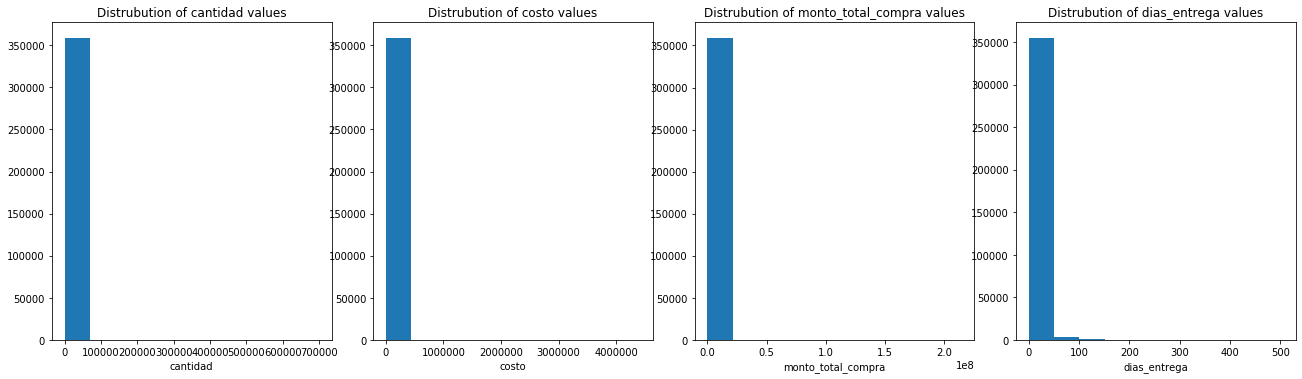

In [7]:
f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(18,5))
f.tight_layout()
ax = [ax1, ax2, ax3, ax4]
col = ['cantidad', 'costo', 'monto_total_compra', 'dias_entrega']
for i in range (len(ax)):
    x_hist = df[col[i]]

    ax[i].hist(x = x_hist, bins = 10)
    ax[i].set_xlabel(col[i])
    ax[i].set_title('Distrubution of ' + col[i] + ' values')

**Observaciones:**
* En efecto, las variables contienen Outliers.

Visualización de outliers en 'dias_entrega'.

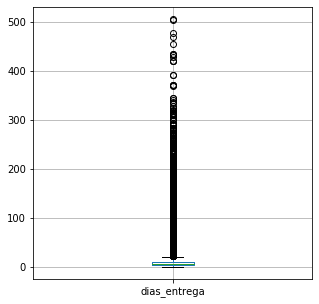

In [8]:
ax = df[['dias_entrega']].boxplot(figsize = (5,5))

#### Descubrimientos

* El dataset cuenta con los valores completos.
* El dataset cuenta con 10 variables del tipo int64, de las cuales muchas son categóricas.
* Las variables 'cantidad', 'costo', 'monto_total_compra', 'dias_entrega' cuentan con varios outliers que podrían afectar con la modelación.
* Las variables 'id_compra', 'tamanio' y 'fecha_creacion' tienen demasiadas categorías.


#### Conclusiones
* Será necesario redefinir el tipo de variable para el dataset.
* Se contemplarán métodos para lidear los outliers de las variables antes mencionadas..
* Se debe eliminar una de las variables 'cantidad', 'costo', 'monto_total_compra' para evitar multicolinealidad.
* Se tienen que derivar variables de la variables origen'id_compra' y 'fecha_creacion' para poder obtener información de ellas.
    * id_compra:
        * Pedidos totales realizados a un proveedor.
        * Número de productos ofrecidos por un proveedor.
        * Número de pedidos realizados con el mismo id_compra
        
    * fecha_creacion:
        * Día de la semana en la que se hace el pedido.
        * Més en el que se hace el pedido.
        
* Después de la derivación podremos prescindir de las variables 'fecha_entrega', 'fecha_creacion', 'tamanio', 'id_compra', 'id_producto'

### 2.2. Limpieza y derivación

Los valores de los outliers serán limitados utilizanco como límite tres veces el rango intercuartílico.

Tratamiento de outliers de 'dias_entrega'.

In [9]:
limit = describe.dias_entrega['75%']+3*(describe.dias_entrega['75%']-describe.dias_entrega['25%'])
df.loc[df['dias_entrega'] > limit, 'dias_entrega'] = limit

Tratamiento de outliers de 'monto_total_compra'.

In [10]:
limit = describe.monto_total_compra['75%']+3*(describe.monto_total_compra['75%']-describe.monto_total_compra['25%'])
df.loc[df['monto_total_compra'] > limit, 'monto_total_compra'] = limit

Tratamiento de outliers de 'cantidad'.

In [11]:
limit = describe.cantidad['75%']+3*(describe.cantidad['75%']-describe.cantidad['25%'])
df.loc[df['cantidad'] > limit, 'cantidad'] = limit

Redefinición del tipo de variables en el dataset.

In [12]:
df["id_proveedor"] = df["id_proveedor"].astype('category')
df["id_empresa_facturadora"] = df["id_empresa_facturadora"].astype('category')
df["id_producto"] = df["id_producto"].astype('category')
df["marca"] = df["marca"].astype('category')
df["sucursal_destino"] = df["sucursal_destino"].astype('category')
df["vendedor"] = df["vendedor"].astype('category')
df["tipo_venta"] = df["tipo_venta"].astype('category')

df['fecha_creacion'] = pd.to_datetime(df['fecha_creacion'])

Derivación de las variables dependientes de los ID's.

In [13]:
counts_pedidos_totales = df.groupby(['id_proveedor'])['id_producto'].count()
df['num_pedidos_totales'] = df.apply(lambda x : counts_pedidos_totales.loc[x.id_proveedor], axis=1)

counts_productos = df.groupby(['id_proveedor'])['id_producto'].apply(lambda x: len(np.unique(x)))
df['num_productos'] = df.apply(lambda x : counts_productos.loc[x.id_proveedor], axis=1)

counts_pedidos = df.groupby(['id_compra'])['id_producto'].count()
df['num_pedidos'] = df.apply(lambda x : counts_pedidos.loc[x.id_compra], axis=1)

Derivación de las variables dependientes de la 'fecha_creacion'

In [14]:
df['month'] = df.apply(lambda x : x.fecha_creacion.month, axis=1)
df['weekday'] = df.apply(lambda x : x.fecha_creacion.isoweekday(), axis=1)

In [15]:
df.drop(['fecha_entrega', 'fecha_creacion', 'tamanio', 'costo', 
         'id_compra', 'id_producto'], axis=1, inplace=True)

### 2.3. Análisis de correlaciones

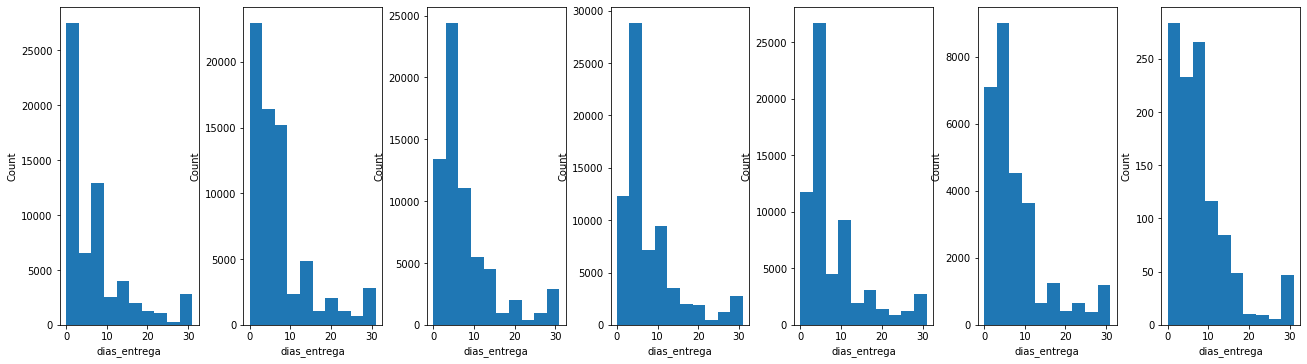

In [16]:
f, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7, figsize=(18,5))
f.tight_layout()
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
weekday = df.weekday.unique()

for i in range (1, len(ax)+1):
    ax[i-1].hist(x = df.query(f'weekday == {i}')['dias_entrega'], bins = 10)
    ax[i-1].set_xlabel('dias_entrega')
    ax[i-1].set_ylabel('Count')


Matriz de correlaciones.

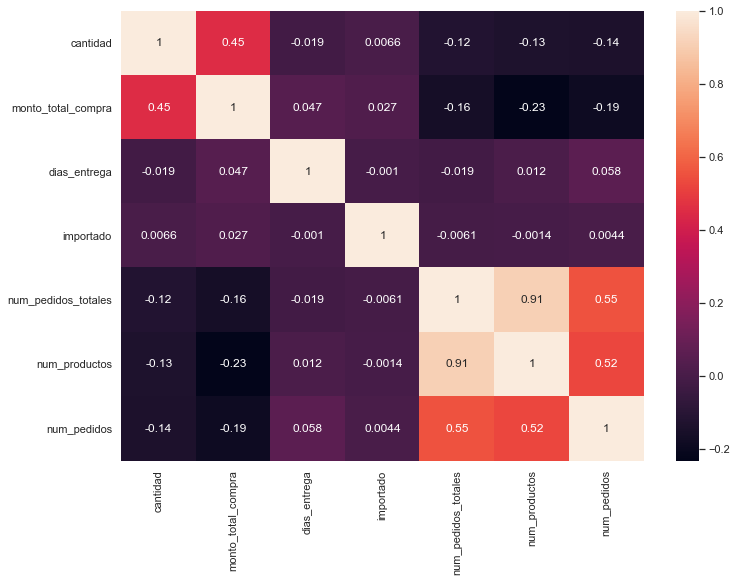

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
axis = sns.heatmap(df.drop(['month','weekday'], axis=1).corr(), annot=True)

#### Descubrimientos

* No se observa correlación entre los días de la semana y la variable objetivo.
* 'num_pedidos_totales' y 'num_productos' tienen una correlación muy alta.


#### Conclusiones
* Podemos prescindir de la variable 'weekday'.
* Se debe evitar la multicolinealidad generada por 'num_pedidos_totales' y 'num_productos'.

## 3. Ingeniería de Características

In [18]:
df.drop(['weekday', 'num_productos'], axis=1, inplace=True)

Codificación de las variables categóricas.

Las variables 'id_proveedor', 'id_empresa_facturadora', 'marca' contienen demasiadas categorías por lo que no se realizará un One Hot Encoding.

In [19]:
df["id_proveedor"] = df["id_proveedor"].cat.codes
df["id_empresa_facturadora"] = df["id_empresa_facturadora"].cat.codes
df["marca"] = df["marca"].cat.codes
df["tipo_venta"] = df["tipo_venta"].cat.codes

In [20]:
list_ = ['month', 'sucursal_destino', 'vendedor']

for column in list_:
    dummies_ = pd.get_dummies(df[column], prefix = '{}'.format(column))
    df = df.join(dummies_)    
df.drop(list_ , axis=1, inplace=True)

## 4. Modelación 

### 4.1. Particionado

Asignación de la variable objetivo, las características y el particionado de la data.

Se tomará el 20% de los datos como test y el resto como data de entrenamiento.

In [21]:
X =  df.drop(columns = ['dias_entrega'])
y = df['dias_entrega']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f'Las dimenciones de X_train: {X_train.shape}')
print(f'Las dimenciones de X_test: {X_test.shape}')

Las dimenciones de X_train: (287656, 51)
Las dimenciones de X_test: (71914, 51)


### 4.2. Entrenamiento

Modelación con un XGBRegressor.

* El algoritmo XGBRegressor es un algoritmo de ensamble, es decir, el algoritmo está compuesto por el entranamiento de multiples algoritmos simples.
* Se trata de un algoritmo Boosting, es decir que los estimadores van entrenandose 'en serie', lo que le permite al clasificado aprender de el error del algoritmo anterior.
* Este algortmo además nos permite realizar un análisis de importancia de características que nos ayuda a describir el fenómeno estudiado.

In [22]:
model = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, gamma = 0.003, n_estimators = 100)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.003, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 4.3. Evaluación

In [23]:
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("MSE de training: %f" % (mse))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE de testing: %f" % (mse))

MSE de training: 34.058379
MSE de testing: 37.132889


**Observaciones:**
* Si obtenemos la raíz cuadrada de los MSE obtenemos:
    * RMSE de training: 5.836 días
    * RMSE de testing: 6.094 días

Análisis de las variables más significativas para la predicción.

id_empresa_facturadora, 0.04213258624076843
tipo_venta, 0.07576905190944672
num_pedidos_totales, 0.05894436687231064
sucursal_destino_C01, 0.05318249762058258


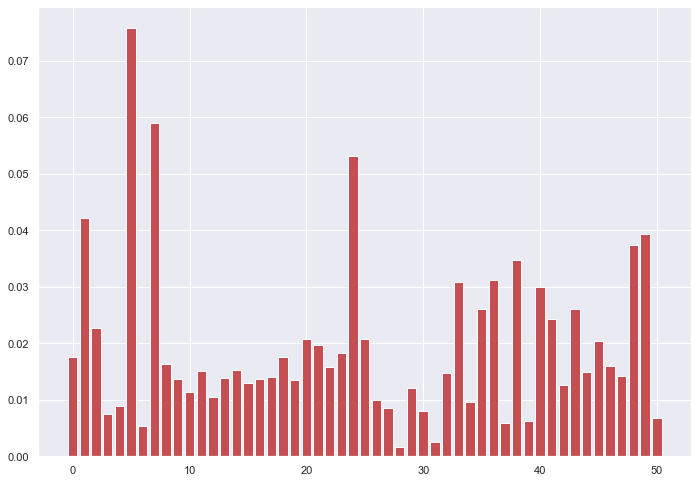

In [24]:
fi = model.feature_importances_
columns = list(df.drop(columns = ['dias_entrega']).columns)
s_columns=[]

for i in range(len(fi)):
    if fi[i] > 0.04:
        print(f'{columns[i]}, {fi[i]}')
        s_columns.append(columns[i])

        plt.bar([i for i in range(len(fi))], fi)
plt.show()

## 5. Conclusión

El algoritmo XGBRegressor nos permitió obtener un error de aproximadamente 6 días en la predicción de los resultados. Con en análisis de la importancia de las características se podría regresar a la Ingeniería de características y hacer modificaciones pertinentes para poder utilizar modelos con un grado mayor de complejidad que nos pueden ayudar a modelar de mejor manera nuestra data.